# Level 1 EDA for the Dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import swifter
import PIL
import cv2
from sklearn.model_selection import train_test_split
from libs.location import *


In [4]:
import os

In [5]:
for file in os.listdir(DATASET_LOCATION_PATH):
    print(file)

stage_2_test_images
stage_2_train_labels.csv
stage_2_train_images
stage_2_detailed_class_info.csv
stage_2_sample_submission.csv
025375ff-f79d-42ab-a443-b0d5671eaffc.dcm
y.npy
X.npy
GCP Credits Request Link - RSNA.txt
.DS_Store
df.csv


In [6]:
train_labels = pd.read_csv(f'{DATASET_LOCATION_PATH}/stage_2_train_labels.csv')
class_info =  pd.read_csv(f'{DATASET_LOCATION_PATH}/stage_2_detailed_class_info.csv')

In [7]:
train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [8]:
class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [9]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [10]:
class_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [11]:
class_info['class'].value_counts()

class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64

In [12]:
df = pd.merge(
    train_labels,
    class_info,
    left_on='patientId',
    right_on='patientId'
)

In [13]:
df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


## Total number of images in training folder

In [14]:
len(os.listdir(f'{DATASET_LOCATION_PATH}/stage_2_train_images'))

26684

## Total number of images in test folder

In [15]:
len(os.listdir(f'{DATASET_LOCATION_PATH}/stage_2_test_images'))

3000

In [16]:
len(df)

37629

In [17]:
df_patient_ids = list(set(df.patientId))
len(df_patient_ids)

26684

In [18]:
df['image_location'] = df['patientId'].apply(lambda x:f'{TRAINING_IMG_LOCATION_PATH}/{x}.dcm')

In [19]:
df.head()

,patientId,x,y,width,height,Target,class,image_location
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/home/nitin/workspace/local_datasets/xray-data...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/home/nitin/workspace/local_datasets/xray-data...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/home/nitin/workspace/local_datasets/xray-data...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,/home/nitin/workspace/local_datasets/xray-data...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,/home/nitin/workspace/local_datasets/xray-data...


In [20]:
def extract_dicom_features(row):
    ds = pydicom.filereader.dcmread(row.image_location)
    row['sex'] = ds.PatientSex
    row['age'] = ds.PatientAge
    return row    

In [21]:
df = df.swifter.apply(lambda row:extract_dicom_features(row),axis=1)

Pandas Apply: 100%|██████████| 37629/37629 [00:32<00:00, 1143.97it/s]


In [23]:
df.head()

,patientId,x,y,width,height,Target,class,image_location,sex,age
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/home/nitin/workspace/local_datasets/xray-data...,F,51
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/home/nitin/workspace/local_datasets/xray-data...,F,48
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/home/nitin/workspace/local_datasets/xray-data...,M,19
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,/home/nitin/workspace/local_datasets/xray-data...,M,28
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,/home/nitin/workspace/local_datasets/xray-data...,F,32


### Save Dataframe

In [25]:
df.to_csv(f'{DATASET_LOCATION_PATH}/df.csv')

In [27]:
df.head()

,patientId,x,y,width,height,Target,class,image_location,sex,age
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/home/nitin/workspace/local_datasets/xray-data...,F,51
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/home/nitin/workspace/local_datasets/xray-data...,F,48
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/home/nitin/workspace/local_datasets/xray-data...,M,19
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,/home/nitin/workspace/local_datasets/xray-data...,M,28
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,/home/nitin/workspace/local_datasets/xray-data...,F,32


<Axes: xlabel='class', ylabel='count'>

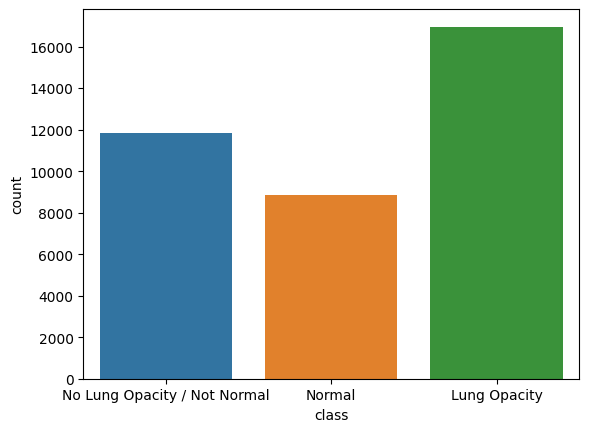

In [28]:
sns.countplot(data=df,x='class')

In [43]:
round((df['class'].value_counts()/df['class'].count())*100,2).to_frame()

,count
class,
Lung Opacity,45.06
No Lung Opacity / Not Normal,31.41
Normal,23.52


In [44]:
orginal_dataset = df.copy()

In [45]:
df.head(5)

,patientId,x,y,width,height,Target,class,image_location,sex,age
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/home/nitin/workspace/local_datasets/xray-data...,F,51
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/home/nitin/workspace/local_datasets/xray-data...,F,48
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/home/nitin/workspace/local_datasets/xray-data...,M,19
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,/home/nitin/workspace/local_datasets/xray-data...,M,28
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,/home/nitin/workspace/local_datasets/xray-data...,F,32


In [63]:
df_binary_cf = df[[
    'patientId',
    'sex',
    'age',
    'image_location',
    'Target'
]].rename(columns={"Target":"is_abnormal"}).drop_duplicates()

In [64]:
df_binary_cf.head()

,patientId,sex,age,image_location,is_abnormal
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,F,51,/home/nitin/workspace/local_datasets/xray-data...,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,F,48,/home/nitin/workspace/local_datasets/xray-data...,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,M,19,/home/nitin/workspace/local_datasets/xray-data...,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,M,28,/home/nitin/workspace/local_datasets/xray-data...,0
4,00436515-870c-4b36-a041-de91049b9ab4,F,32,/home/nitin/workspace/local_datasets/xray-data...,1


In [65]:
df_binary_cf.iloc[0].image_location

'/home/nitin/workspace/local_datasets/xray-dataset/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm'

In [66]:
len(df_binary_cf)

26684

In [71]:
print('Pillow Version:', PIL.__version__)

Pillow Version: 9.4.0


In [75]:
image = PIL.Image.open('/home/nitin/workspace/notebooks/pneumonia-detection/stage_2_train_images_jpg/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm.jpg')


In [80]:
image.format,image.size,image.mode

('JPEG', (1024, 1024), 'L')

In [89]:
np.array(image.resize(size=(224,224)))

array([[ 83,  42,  22, ...,  65, 114, 154],
       [ 26,   9,   3, ...,  12,  43,  98],
       [  5,   2,   2, ...,   0,   7,  34],
       ...,
       [  5,   3,   3, ...,   1,   4,   8],
       [  7,   4,   3, ...,   1,   5,  10],
       [ 11,   6,   5, ...,   3,   8,  13]], dtype=uint8)

In [90]:
patient_ids = list(df_binary_cf['patientId'])

In [126]:
X_array = []

In [127]:
DATASET_LOCATION_PATH

'/home/nitin/workspace/local_datasets/xray-dataset'

In [128]:
from tqdm import tqdm

In [129]:
IMG_PATH='/home/nitin/workspace/notebooks/pneumonia-detection/stage_2_train_images_jpg'

In [130]:
for patient_id in tqdm(patient_ids):
    img_path = f'{IMG_PATH}/{patient_id}.dcm.jpg'
    img = cv2.imread(img_path)
    new_array = cv2.resize(img, (224, 224))
    X_array.append(new_array)

100%|██████████| 26684/26684 [02:52<00:00, 154.49it/s]


In [131]:
len(X_array)

26684

In [132]:
X = np.array(X_array).reshape(-1,224, 224, 3)


In [133]:
X.shape

(26684, 224, 224, 3)

In [134]:
y_label = df_binary_cf['is_abnormal'].values

In [135]:
from keras.utils import to_categorical

In [136]:
y = to_categorical(y_label,dtype='uint8')

In [125]:
y.shape

(26684, 2)

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [139]:
CHECKPOINT_LOCATION_PATH

'/home/nitin/workspace/local_datasets/xray-dataset/checkpoints'

In [141]:
np.save(f'{CHECKPOINT_LOCATION_PATH}/X',X)
np.save(f'{CHECKPOINT_LOCATION_PATH}/y',y)